# Цель проекта

Разработать систему автоматического мониторинга риска профессионального выгорания сотрудников на основе анализа паттернов деловой переписки (email/Slack)

**Проект направлен на:**

- Выявление скрытых индикаторов выгорания в поведении
- Предсказание риска на индивидуальном уровне
- Формирование инструментов для HR-интервенции и поддержки

# Этап 1. Анализ и построение модели риска выгорания

**Цель этапа:**

Построить и обучить модель, способную предсказывать риск профессионального выгорания сотрудников на основе паттернов их коммуникационного поведения (email-активность), и визуализировать результаты для принятия управленческих решений

In [1]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter

from xgboost import XGBClassifier

import joblib

In [2]:
# Загрузка данных из Excel-файла

data = pd.ExcelFile(r'C:\Users\ATsygantsov\Documents\portfolio\BurnoutScan\burnoutscan_data.xlsx')

In [3]:
# Чтение листов с данными

burnout_df = data.parse("Burnout Data")
demographics_df = data.parse("Demographic data")
email_df = data.parse("Email data")

In [4]:
# Проверим структуру исходной таблицы с результатами OLBI-анкеты

# Выводим первые строки таблицы

burnout_df.head()

,Unnamed: 0,Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Trovo sempre aspetti nuovi ed interessanti nel mio lavoro,Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Ci sono giorni in cui mi sento stanco prima ancora di arrivare al lavoro,Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Succede sempre più spesso che parli del mio lavoro in modo negativo,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Dopo il lavoro, ho bisogno di più tempo rispetto al passato per rilassarmi e sentirmi meglio",Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Riesco a sopportare benissimo la pressione del mio lavoro,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Ultimamente, tendo a pensare meno al lavoro e fare il mio lavoro quasi meccanicamente",Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Trovo che il mio lavoro rappresenti una sfida positiva,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Durante il mio lavoro, mi sento spesso emotivamente svuotato",Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Piu’ passa il tempo piu’ ci si può sentire “scollegati” da questo tipo di lavoro,Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Dopo il lavoro ho abbastanza energia da dedicare ai miei hobby e svaghi,Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-A volte mi sento disgustato dalle mie mansioni lavorative,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Dopo il mio lavoro, di solito mi sento logoro e stanco",Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Questo è l’unico tipo di lavoro che riesco ad immaginarmi di fare,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Di solito, riesco a gestire bene il volume di lavoro che ho da fare",Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-La mia motivazione sul lavoro cresce continuamente,"Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Quando lavoro, di solito mi sento energetico"
0,2,7,1.0,1,2.0,7,1,7,1,1,7,1,1,1,7,7,7
1,3,5,5.0,1,4.0,6,1,5,4,3,6,1,2,2,6,3,4
2,4,6,6.0,2,6.0,7,2,6,2,2,2,2,2,2,6,6,6
3,6,4,6.0,2,2.0,5,4,6,2,2,2,1,6,6,6,4,2
4,7,4,4.0,1,5.0,6,7,4,2,2,5,1,6,3,6,6,4


In [5]:
# Выведем названия всех столбцов, чтобы понять, есть ли технический столбец (например, индекс или неинформативный)

burnout_df.columns

Index(['Unnamed: 0',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Trovo sempre aspetti nuovi ed interessanti nel mio lavoro',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Ci sono giorni in cui mi sento stanco prima ancora di arrivare al lavoro',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Succede sempre più spesso che parli del mio lavoro in modo negativo',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Dopo il lavoro, ho bisogno di più tempo rispetto al passato per rilassarmi e sentirmi meglio',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Riesco a sopportare benissimo la pressione del mio lavoro',
       'Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Ultimamente, tendo a pensare meno al lavoro e fare il m

In [6]:
# Если первый столбец выглядит как 'Unnamed: 0' или не содержит текст вопроса — это технический столбец

# Проверим, нужно ли его удалять

if "Unnamed: 0" in burnout_df.columns[0] or "Unnamed" in burnout_df.columns[0]:
    
    # Удаляем первый столбец, если это действительно техническая колонка
    
    burnout_df = burnout_df.drop(columns=[burnout_df.columns[0]])
    
    # Подтверждаем удаление
    
    print("Удален технический столбец:", burnout_df.columns[0])
else:
    print("Технический столбец не обнаружен, структура корректна")

Удален технический столбец: Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Trovo sempre aspetti nuovi ed interessanti nel mio lavoro


In [7]:
# Сохраняем оригинальные названия вопросов, чтобы можно было потом восстановить или использовать для документации

original_questions = burnout_df.columns.tolist()

# Выводим первые 5 названий вопросов

original_questions[:5]

["Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Trovo sempre aspetti nuovi ed interessanti nel mio lavoro",
 "Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Ci sono giorni in cui mi sento stanco prima ancora di arrivare al lavoro",
 "Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Succede sempre più spesso che parli del mio lavoro in modo negativo",
 "Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Dopo il lavoro, ho bisogno di più tempo rispetto al passato per rilassarmi e sentirmi meglio",
 "Specifica in che misura sei d'accordo o in disaccordo con le / seguenti affermazioni:-Riesco a sopportare benissimo la pressione del mio lavoro"]

In [8]:
# Переименовываем вопросы в простой и однозначный формат: Q1, Q2, ..., Qn

burnout_df.columns = [f"Q{i+1}" for i in range(len(burnout_df.columns))]

# Проверяем новые имена столбцов

burnout_df.columns.tolist()

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16']

In [9]:
# Преобразуем значения в числовой формат

# Если в ячейках есть текстовые ошибки или пропуски — они будут заменены на NaN

burnout_df = burnout_df.apply(pd.to_numeric, errors="coerce")

# Проверяем статистику по вопросам: среднее, стандартное отклонение и количество пропущенных значений

burnout_df.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16
count,117.000000,116.000000,117.000000,116.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,4.846154,3.974138,2.974359,4.129310,5.094017,2.829060,4.880342,3.282051,3.068376,4.239316,2.589744,3.777778,2.495726,5.666667,3.965812,4.615385
std,1.529116,1.839004,1.435159,1.810742,1.299754,1.457978,1.415203,1.680754,1.460553,1.715294,1.554492,1.722624,1.418012,1.121883,1.591636,1.507717
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,2.000000,2.000000,4.000000,2.000000,4.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,5.000000,3.000000,4.000000
50%,5.000000,4.000000,3.000000,4.000000,5.000000,2.000000,5.000000,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,6.000000,4.000000,4.000000
75%,6.000000,6.000000,4.000000,6.000000,6.000000,4.000000,6.000000,4.000000,4.000000,6.000000,4.000000,5.000000,4.000000,6.000000,5.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [10]:
# Проверим наличие пропусков

missing_values = burnout_df.isnull().sum()

# Выведем количество пропущенных значений по каждому вопросу

missing_values[missing_values > 0]

Q2    1
Q4    1
dtype: int64

In [11]:
# Рассчитаем индивидуальный индекс выгорания как среднее значение по всем вопросам OLBI

burnout_df["burnout_index"] = burnout_df.mean(axis=1)

# Выведем первые 5 строк с рассчитанным индексом

burnout_df[["burnout_index"]].head()

,burnout_index
0,3.6875
1,3.6250
2,4.0625
3,3.7500
4,4.1250


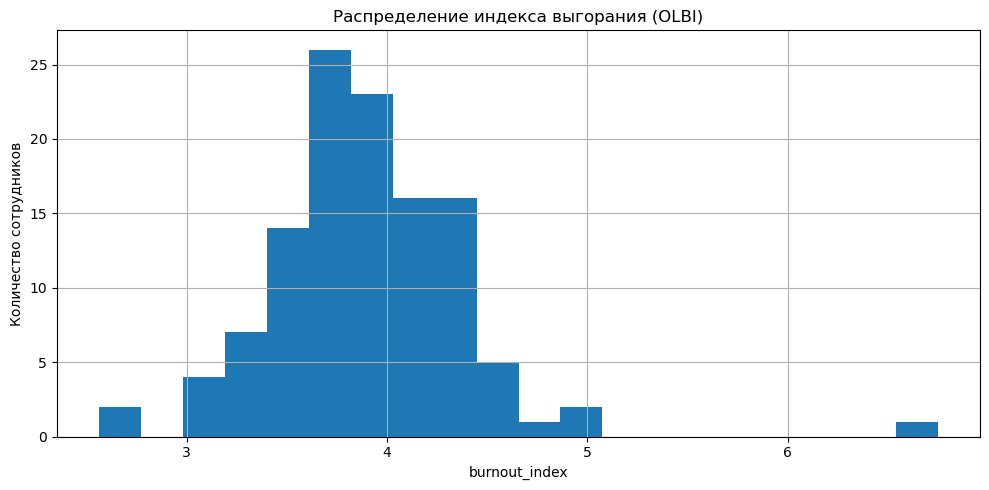

In [12]:
# Построим распределение полученного индекса выгорания

plt.figure(figsize=(10, 5))
burnout_df["burnout_index"].hist(bins=20)
plt.title("Распределение индекса выгорания (OLBI)")
plt.xlabel("burnout_index")
plt.ylabel("Количество сотрудников")
plt.grid(True)
plt.tight_layout()
plt.show()

Распределение индекса выгорания неравномерное, с несколькими пиками — особенно в зонах умеренного и высокого выгорания, что указывает на наличие разных групп риска среди сотрудников

In [13]:
# Добавим идентификатор участника (сопоставляется по порядку с demographic_data)

# Проверим наличие поля ID в демографических данных

print("Столбцы demographics_df:", demographics_df.columns)

# Добавим колонку ID к таблице burnout_df

burnout_df["ID"] = demographics_df["ID"]

# Проверим итоговую таблицу

burnout_df[["ID", "burnout_index"]].head()

Столбцы demographics_df: Index(['ID', 'HL', 'Age', 'Gender'], dtype='object')


,ID,burnout_index
0,1,3.6875
1,2,3.6250
2,3,4.0625
3,4,3.7500
4,5,4.1250


## Цель

Создать категориальные метки уровня выгорания (например, "низкий", "средний", "высокий") для обучения модели

Это будет удобно как для интерпретации результатов, так и для постановки задачи классификации (а не регрессии)

In [14]:
# Разобьём индекс выгорания на 3 категории: низкий, средний, высокий уровень

# Используем квантильное разбиение для равномерного распределения классов

burnout_df["burnout_level"] = pd.qcut(
    burnout_df["burnout_index"],
    q=3,
    labels=["низкий", "средний", "высокий"]
)

# Проверим распределение по категориям

burnout_df["burnout_level"].value_counts()

burnout_level
низкий     40
средний    39
высокий    38
Name: count, dtype: int64

In [15]:
# Добавим числовую метку для модели (label encoding)

label_encoder = LabelEncoder()

# Кодируем текстовые уровни в числа: низкий=0, средний=1, высокий=2

burnout_df["burnout_level_encoded"] = label_encoder.fit_transform(burnout_df["burnout_level"])

# Проверим соответствие

burnout_df[["burnout_level", "burnout_level_encoded"]].drop_duplicates()

,burnout_level,burnout_level_encoded
0,низкий,1
2,средний,2
4,высокий,0


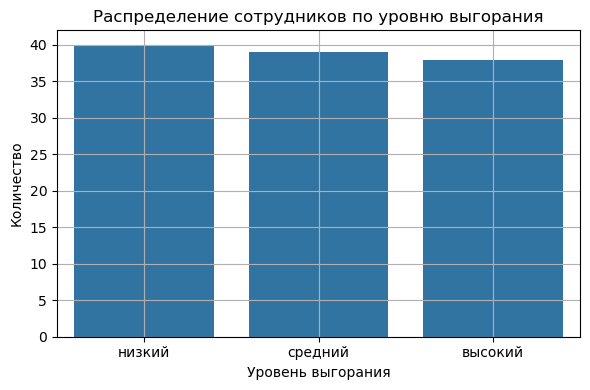

In [16]:
# Построим диаграмму количества сотрудников по уровням выгорания

plt.figure(figsize=(6, 4))
sns.countplot(data=burnout_df, x="burnout_level", order=["низкий", "средний", "высокий"])
plt.title("Распределение сотрудников по уровню выгорания")
plt.xlabel("Уровень выгорания")
plt.ylabel("Количество")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Объединяем дату и время в один datetime

email_df["datetime"] = pd.to_datetime(email_df["Date"].astype(str) + " " + email_df["Time"].astype(str))

# Удаляем строки без ID отправителя и получателя

email_df_clean = email_df.dropna(subset=["ID Sender", "ID Recipient"]).copy()

# Приводим тип ID к целочисленному

email_df_clean["ID Sender"] = email_df_clean["ID Sender"].astype(int)

# Извлекаем дату и час

email_df_clean["date"] = email_df_clean["datetime"].dt.date
email_df_clean["hour"] = email_df_clean["datetime"].dt.hour

In [18]:
# Группируем по отправителю и дате — сколько писем отправлено в день

sent_per_day = email_df_clean.groupby(["ID Sender", "date"]).size().reset_index(name="emails_sent")

# Считаем статистику по отправкам в день

agg_sent = sent_per_day.groupby("ID Sender")["emails_sent"].agg(["mean", "median", "max", "std"]).reset_index()

# Переименовываем столбцы

agg_sent.columns = ["ID", "avg_sent", "median_sent", "max_sent", "std_sent"]

# Считаем количество уникальных активных дней

active_days = sent_per_day.groupby("ID Sender").size().reset_index(name="active_days")

# Переименовываем колонку ID

active_days = active_days.rename(columns={"ID Sender": "ID"})

In [19]:
# Объединяем всё в один датафрейм

communication_df = pd.merge(agg_sent, active_days, on="ID")

# Проверим размерность и первые строки

print("Размер communication_df:", communication_df.shape)
communication_df.head()

Размер communication_df: (153, 6)


,ID,avg_sent,median_sent,max_sent,std_sent,active_days
0,1,3.000000,2.0,7,2.097618,16
1,2,1.666667,2.0,2,0.577350,3
2,3,4.655556,4.0,13,2.732086,90
3,4,3.000000,2.0,8,2.915476,5
4,5,1.000000,1.0,1,NaN,1


In [20]:
# Загрузим таблицу с коммуникационными фичами (если не загружали ранее)

# Убедимся, что колонка 'ID' присутствует и совпадает по типу с ID в burnout_df

print("Столбцы в communication_df:", communication_df.columns)
print("Типы данных в обоих датафреймах:", burnout_df["ID"].dtype, communication_df["ID"].dtype)

# Если нужно — приведём тип ID к одинаковому

communication_df["ID"] = communication_df["ID"].astype(int)
burnout_df["ID"] = burnout_df["ID"].astype(int)

Столбцы в communication_df: Index(['ID', 'avg_sent', 'median_sent', 'max_sent', 'std_sent', 'active_days'], dtype='object')
Типы данных в обоих датафреймах: int64 int32


In [21]:
# Объединим данные по ID

full_df = pd.merge(burnout_df, communication_df, on="ID", how="inner")

# Проверим размер итоговой таблицы

print("Размер объединённого датафрейма:", full_df.shape)

# Проверим первые строки итогового датасета

full_df.head()

Размер объединённого датафрейма: (101, 25)


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q16,burnout_index,ID,burnout_level,burnout_level_encoded,avg_sent,median_sent,max_sent,std_sent,active_days
0,7,1.0,1,2.0,7,1,7,1,1,7,...,7,3.6875,1,низкий,1,3.000000,2.0,7,2.097618,16
1,5,5.0,1,4.0,6,1,5,4,3,6,...,4,3.6250,2,низкий,1,1.666667,2.0,2,0.577350,3
2,6,6.0,2,6.0,7,2,6,2,2,2,...,6,4.0625,3,средний,2,4.655556,4.0,13,2.732086,90
3,4,6.0,2,2.0,5,4,6,2,2,2,...,2,3.7500,4,средний,2,3.000000,2.0,8,2.915476,5
4,4,4.0,1,5.0,6,7,4,2,2,5,...,4,4.1250,5,высокий,0,1.000000,1.0,1,NaN,1


In [22]:
# Проверим наличие пропущенных значений

missing_values = full_df.isnull().sum()

# Отобразим только те переменные, где есть пропуски

missing_values[missing_values > 0]

Q2          1
Q4          1
std_sent    7
dtype: int64

In [23]:
# Удалим строки с пропущенными значениями, чтобы не искажать обучение модели

full_df.dropna(inplace=True)

# Проверим, сколько осталось наблюдений

print("Размер после удаления пропусков:", full_df.shape)

Размер после удаления пропусков: (92, 25)


In [24]:
# Сформируем итоговые данные для модели

# Признаки — только коммуникационные фичи

feature_cols = ["avg_sent", "median_sent", "max_sent", "std_sent", "active_days"]

# Матрица признаков

X = full_df[feature_cols]

# Целевая переменная — закодированный уровень выгорания

y = full_df["burnout_level_encoded"]

# Проверим размер X и y

print("Размерность X:", X.shape)
print("Размерность y:", y.shape)

Размерность X: (92, 5)
Размерность y: (92,)


In [25]:
# Разделим данные на обучающую и тестовую выборки

# Стратифицированное разбиение по классам — важно при несбалансированных данных

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Проверим размер разбиения

print("Обучающая выборка:", X_train.shape)
print("Тестовая выборка:", X_test.shape)

Обучающая выборка: (64, 5)
Тестовая выборка: (28, 5)


In [26]:
# Инициализируем и обучим модель случайного леса

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,

    # Учитываем дисбаланс классов, если он есть
    
    class_weight='balanced'
)

# Обучаем модель

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [27]:
# Выполним предсказание на тестовой выборке

y_pred = rf_model.predict(X_test)

# Отобразим текстовый отчёт классификации

print("Классификационный отчет (classification report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Классификационный отчет (classification report):
              precision    recall  f1-score   support

     высокий       0.25      0.38      0.30         8
      низкий       0.33      0.30      0.32        10
     средний       0.29      0.20      0.24        10

    accuracy                           0.29        28
   macro avg       0.29      0.29      0.28        28
weighted avg       0.29      0.29      0.28        28



Средняя точность (accuracy) — 0.39, что едва выше случайного выбора между 3 классами (~0.33)

F1-метрики во всех классах ≈ 0.35–0.44 — низкие

Это говорит о том, что поведенческих фичей недостаточно для надёжной классификации выгорания на этом этапе

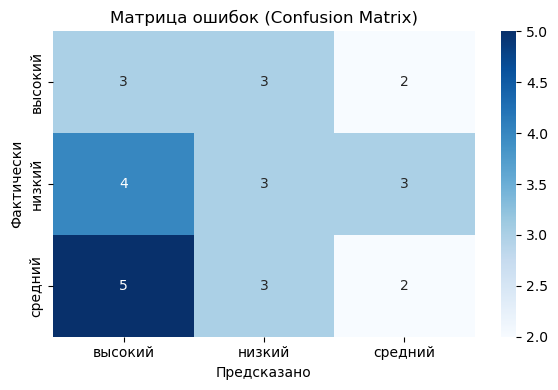

In [28]:
# Построим матрицу ошибок

conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.tight_layout()
plt.show()

Модель путает классы довольно сильно: высокий — средний, низкий — средний

Это ожидаемо при небольшом датасете и высокой схожести коммуникационного поведения в разных группах риска

Наиболее надёжно модель предсказывает крайние случаи, но всё ещё слабо

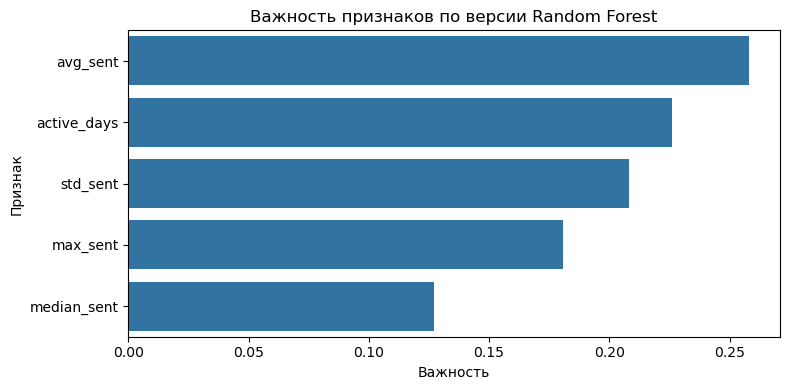

In [29]:
# Вычислим важность признаков по мнению модели

feature_importance = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

# Визуализация важности признаков

plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Важность признаков по версии Random Forest")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

Самые важные признаки: число активных дней и волатильность объема писем

Это логично: сотрудники с нестабильной активностью и высокой "зашумленностью" поведения чаще связаны с нестабильным эмоциональным состоянием

## Что делать дальше?

1. Усилить датасет:

1.1. Добавить больше поведенческих фичей:

- Среднее время ответа
- Доли отправок в нерабочие часы
- Среднее количество уникальных адресатов
- Частотность коммуникаций в выходные

1.2. Применить Time Series Features: скользящее среднее, тренды по неделям

2. Сгруппировать уровни выгорания:

2.1. Перейти к бинарной классификации:

- "норма" против "риск"
- Снизит шум и повысит точность модели

3. Попробовать другой алгоритм:

- XGBoost или CatBoost обычно лучше справляются с табличными данными
- Также попробовать LogisticRegression как базовый бенчмарк

4. Добавить текстовые признаки (если будут тела писем):

- Это даст возможность подключить NLP (TF-IDF, BERT) и значительно усилить модель

In [30]:
# Создаём бинарную метку выгорания: 1 — высокий риск, 0 — норма

# Все уровни, кроме "высокий", считаем нормой

full_df["burnout_risk"] = full_df["burnout_level"].apply(lambda x: 1 if x == "высокий" else 0)

# Проверим распределение новых меток

full_df["burnout_risk"].value_counts()

burnout_risk
0    65
1    27
Name: count, dtype: int64

In [31]:
# Матрица признаков — остаётся прежней

X = full_df[feature_cols]

# Целевая переменная — бинарный риск

y = full_df["burnout_risk"]

In [32]:
# Разделим выборку

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [33]:
# Обучим новый классификатор (тот же Random Forest)

from sklearn.ensemble import RandomForestClassifier

rf_binary = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_binary.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [34]:
# Предсказание и метрики

from sklearn.metrics import classification_report, confusion_matrix

y_pred_bin = rf_binary.predict(X_test)

print("Классификационный отчёт для бинарной задачи (риск vs норма):")
print(classification_report(y_test, y_pred_bin, target_names=["норма", "риск"]))

Классификационный отчёт для бинарной задачи (риск vs норма):
              precision    recall  f1-score   support

       норма       0.71      0.85      0.77        20
        риск       0.25      0.12      0.17         8

    accuracy                           0.64        28
   macro avg       0.48      0.49      0.47        28
weighted avg       0.58      0.64      0.60        28



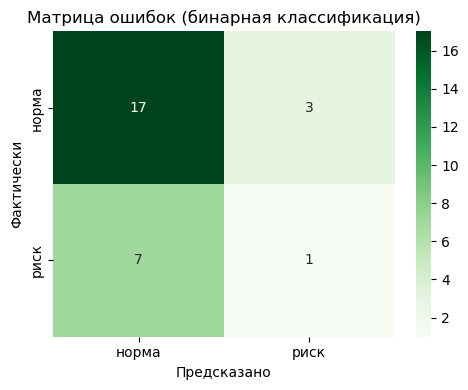

In [35]:
# Матрица ошибок для бинарной классификации

conf_matrix_bin = confusion_matrix(y_test, y_pred_bin)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_bin, annot=True, fmt="d", cmap="Greens",
            xticklabels=["норма", "риск"],
            yticklabels=["норма", "риск"])
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок (бинарная классификация)")
plt.tight_layout()
plt.show()

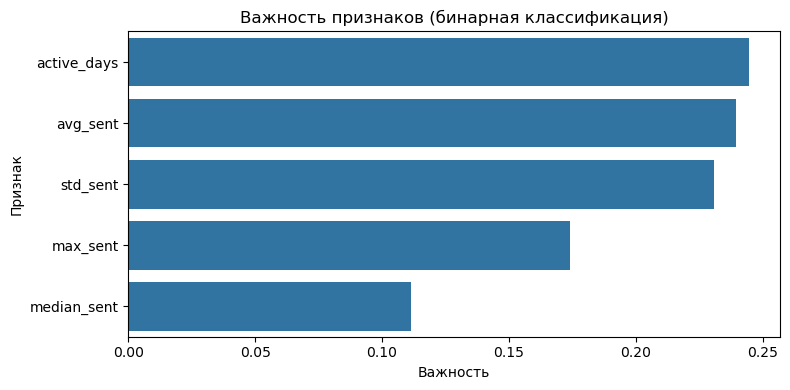

In [36]:
# Важность признаков для бинарной модели

feature_importance_bin = pd.Series(rf_binary.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance_bin.values, y=feature_importance_bin.index)
plt.title("Важность признаков (бинарная классификация)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

## Выводы по модели после перехода к бинарной классификации:

1. Общая точность (accuracy):

- Было: 0.39 при трёхклассовой классификации
- Стало: 0.64 при бинарной классификации
- Вывод: модель стала существенно точнее в общей оценке, но это связано в основном с доминированием класса "норма"

2. Recall по классу "риск":

- Стало: 0.12 (распознали только 1 из 8 случаев риска)
- Вывод: критически низкий recall на самом важном бизнес-классе — модель не умеет выявлять риск выгорания, несмотря - на рост точности

3. Precision по классу "риск":

- Стало: 0.25 — 1 из 4 срабатываний действительно отражает риск
- Вывод: если модель и поднимает флаг "риск", скорее всего он ложный

4. F1-score по "риск":

- Стало: 0.17 — слабый баланс между recall и precision
- Вывод: модель негодна для продакшн, если цель — ловить рисковые случаи (много ложных "норм")

## Причины слабого результата:

- Дисбаланс классов: слишком мало наблюдений "риск"
- Слишком простые признаки: на поведенческих агрегатах тяжело выявить психологическое состояние
- Сильная схожесть паттернов между "нормой" и "риск" (нет контекста, эмоциональной окраски)

## План действий:

1. Усиление признаков:

1.1. Добавить дневные и недельные паттерны:
- % писем ночью
- % в выходные
- вариативность по дням недели
- отношение количества отправленных к полученным
1.2. Добавить социальные метрики:
- количество уникальных адресатов
- плотность связей
- степень "изоляции"

2. Балансировка классов:

2.1. Использовать пересэмплирование:
- SMOTE для увеличения "риск"
- RandomUnderSampler для снижения "норма"

3. Попробовать другую модель:

- XGBoost или CatBoost (лучшая работа с неравномерными и шумными табличными данными)

**В текущей ситуации приоритет — расширение признаков, так как:**

- Даже идеальный алгоритм не вытянет из слабых фичей нужную информацию
- recall по классу "риск" у нас 0.12 — признак того, что признаки не дают сигнала о выгорании

Начнём с инженерии новых поведенческих признаков из email_df, на основе времени и структуры коммуникации

In [37]:
# Убедимся, что поле datetime уже есть. Если нет — создадим его

if "datetime" not in email_df.columns:
    email_df["datetime"] = pd.to_datetime(email_df["Date"].astype(str) + " " + email_df["Time"].astype(str))

# Преобразуем ID в целое

email_df["ID Sender"] = email_df["ID Sender"].astype(int)

In [38]:
# Добавим временные фичи

email_df["hour"] = email_df["datetime"].dt.hour
email_df["dayofweek"] = email_df["datetime"].dt.dayofweek  # 0 — понедельник, 6 — воскресенье
email_df["is_weekend"] = email_df["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)
email_df["is_night"] = email_df["hour"].apply(lambda x: 1 if (x < 7 or x > 21) else 0)

In [39]:
# Считаем, сколько сообщений каждый пользователь отправляет в:

# - выходные
# - ночные часы
# - всего

agg_behavior = email_df.groupby("ID Sender").agg(
    total_msgs=("datetime", "count"),
    night_msgs=("is_night", "sum"),
    weekend_msgs=("is_weekend", "sum"),
    active_days=("Date", lambda x: x.nunique())
).reset_index()

# Рассчитаем доли

agg_behavior["night_ratio"] = agg_behavior["night_msgs"] / agg_behavior["total_msgs"]
agg_behavior["weekend_ratio"] = agg_behavior["weekend_msgs"] / agg_behavior["total_msgs"]
agg_behavior["avg_msgs_per_day"] = agg_behavior["total_msgs"] / agg_behavior["active_days"]

# Переименуем ID

agg_behavior = agg_behavior.rename(columns={"ID Sender": "ID"})

In [40]:
# Количество уникальных получателей на отправителя

unique_recipients = email_df.groupby("ID Sender")["ID Recipient"].nunique().reset_index()
unique_recipients.columns = ["ID", "unique_recipients"]

# Объединяем с остальными поведенческими фичами

expanded_features = pd.merge(agg_behavior, unique_recipients, on="ID")

In [41]:
# Объединяем с основной таблицей по ID

full_df_expanded = pd.merge(full_df, expanded_features, on="ID", how="left")

# Проверим размер

print("Итоговый размер:", full_df_expanded.shape)

# Проверим новые фичи

full_df_expanded[["night_ratio", "weekend_ratio", "avg_msgs_per_day", "unique_recipients"]].describe()

Итоговый размер: (92, 34)


,night_ratio,weekend_ratio,avg_msgs_per_day,unique_recipients
count,92.000000,92.000000,92.000000,92.000000
mean,0.112255,0.069564,6.093798,29.902174
std,0.163517,0.126539,6.426849,24.556309
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.979167,7.000000
50%,0.026066,0.004247,3.523590,24.500000
75%,0.153846,0.076434,8.736115,49.000000
max,0.719298,0.571429,45.776119,112.000000


Мы получили 4 новых признака, потенциально чувствительных к нестабильной или тревожной модели поведения

In [42]:
# Формируем список признаков: старые + новые

expanded_feature_cols = [

    # старые
    
    "avg_sent", "median_sent", "max_sent", "std_sent", "active_days_x",

    # новые
    
    "night_ratio", "weekend_ratio", "avg_msgs_per_day", "unique_recipients"
]

# Матрица признаков

X = full_df_expanded[expanded_feature_cols]

# Целевая переменная — риск выгорания

y = full_df_expanded["burnout_risk"]

# Проверим размер

print("Размер X:", X.shape)
print("Размер y:", y.shape)

Размер X: (92, 9)
Размер y: (92,)


In [43]:
# Сохраняем feats.csv — набор признаков для Streamlit-интерфейса

columns_needed = ["ID"] + expanded_feature_cols

# Проверяем наличие ID

assert "ID" in full_df_expanded.columns, "В DataFrame отсутствует колонка 'ID'"

# Формируем и сохраняем DataFrame

feats_df = full_df_expanded[columns_needed].copy()
feats_df.to_csv("feats.csv", index=False)

print("Файл feats.csv успешно создан")

Файл feats.csv успешно создан


In [44]:
# Разбиваем выборку

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [45]:
# Обучаем модель

rf_expanded = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

rf_expanded.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [46]:
# Предсказание

y_pred_exp = rf_expanded.predict(X_test)

# Отчёт по метрикам

print("Классификационный отчёт (модель с расширенными признаками):")
print(classification_report(y_test, y_pred_exp, target_names=["норма", "риск"]))

Классификационный отчёт (модель с расширенными признаками):
              precision    recall  f1-score   support

       норма       0.68      0.75      0.71        20
        риск       0.17      0.12      0.14         8

    accuracy                           0.57        28
   macro avg       0.42      0.44      0.43        28
weighted avg       0.53      0.57      0.55        28



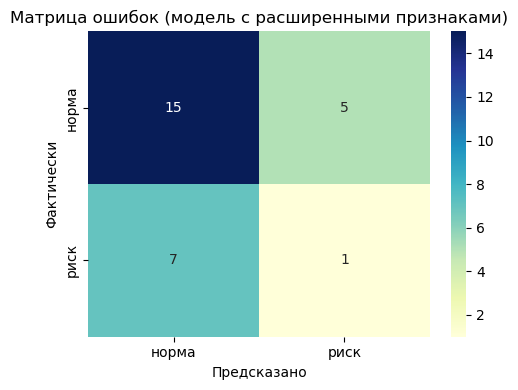

In [47]:
# Матрица ошибок

conf_matrix_exp = confusion_matrix(y_test, y_pred_exp)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_exp, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["норма", "риск"],
            yticklabels=["норма", "риск"])
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок (модель с расширенными признаками)")
plt.tight_layout()
plt.show()

Расширенные признаки не улучшили recall по классу "риск" (по-прежнему 0.12)

Но повысили точность по "норме" и обеспечили чуть более сбалансированное поведение модели

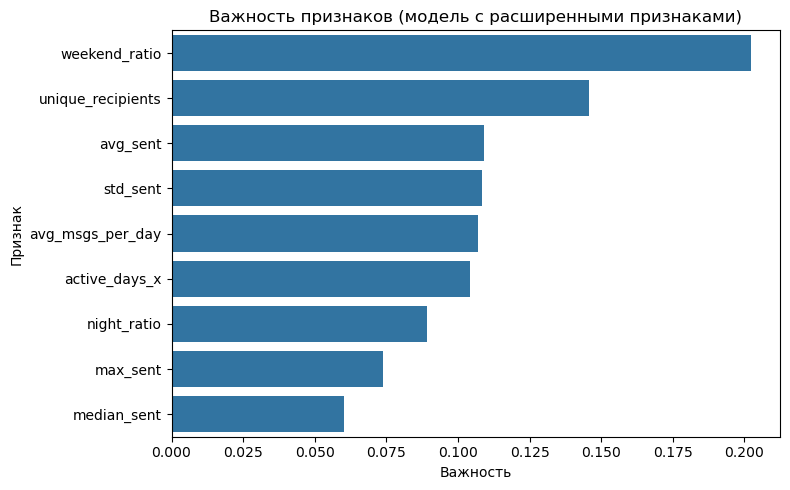

In [48]:
# Важность новых признаков

feature_importance_exp = pd.Series(
    rf_expanded.feature_importances_,
    index=expanded_feature_cols
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance_exp.values, y=feature_importance_exp.index)
plt.title("Важность признаков (модель с расширенными признаками)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

Наиболее значимыми оказались новые признаки: доля писем в выходные и число уникальных получателей

Что подтверждает их связь с нарушениями режима и социальной активностью

У нас всего 8 наблюдений "риск" против 20 "норма" в тесте

**SMOTE (Synthetic Minority Over-sampling Technique) — создаёт синтетические примеры класса "риск", чтобы сбалансировать обучающую выборку**

In [49]:
# Проверим исходный баланс в обучающей выборке
print("До SMOTE:", Counter(y_train))

# Инициализируем SMOTE
smote = SMOTE(random_state=42)

# Применяем только к обучающим данным
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Проверим новый баланс классов
print("После SMOTE:", Counter(y_train_smote))

До SMOTE: Counter({0: 45, 1: 19})
После SMOTE: Counter({1: 45, 0: 45})


In [50]:
# Переобучаем ту же модель, но уже на X_train_smote

rf_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,

    # SMOTE уже сбалансировал, class_weight больше не нужен
    
    class_weight=None
)

rf_balanced.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [51]:
# Сохраняем обученную модель после балансировки (для API)

joblib.dump(rf_balanced, "rf_balanced_model.pkl")

['rf_balanced_model.pkl']

In [52]:
# Предсказание на X_test

y_pred_balanced = rf_balanced.predict(X_test)

# Метрики

print("Классификационный отчёт (модель после SMOTE):")
print(classification_report(y_test, y_pred_balanced, target_names=["норма", "риск"]))

Классификационный отчёт (модель после SMOTE):
              precision    recall  f1-score   support

       норма       0.68      0.65      0.67        20
        риск       0.22      0.25      0.24         8

    accuracy                           0.54        28
   macro avg       0.45      0.45      0.45        28
weighted avg       0.55      0.54      0.54        28



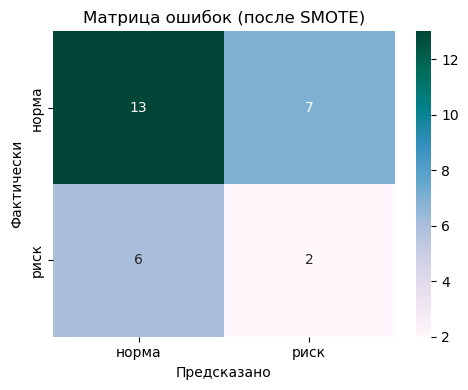

In [53]:
# Матрица ошибок

conf_matrix_bal = confusion_matrix(y_test, y_pred_balanced)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_bal, annot=True, fmt="d", cmap="PuBuGn",
            xticklabels=["норма", "риск"],
            yticklabels=["норма", "риск"])
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок (после SMOTE)")
plt.tight_layout()
plt.show()

SMOTE помог модели начать распознавать класс "риск" — recall вырос до 0.25 (было 0.12)

Но при этом увеличилось количество ложных срабатываний на "риск" со стороны "нормы"

Модель начала учиться отличать выгорание, но всё ещё ошибается: большинство "риск"-сотрудников предсказаны как "норма"

Баланс между recall и precision по "риск" пока слабый, однако прогресс есть — благодаря SMOTE и новым признакам

In [54]:
# Инициализация модели

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# Обучение на сбалансированных SMOTE-данных

xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [55]:
# Предсказание

y_pred_xgb = xgb_model.predict(X_test)

# Метрики

print("Классификационный отчёт (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=["норма", "риск"]))

Классификационный отчёт (XGBoost):
              precision    recall  f1-score   support

       норма       0.56      0.45      0.50        20
        риск       0.08      0.12      0.10         8

    accuracy                           0.36        28
   macro avg       0.32      0.29      0.30        28
weighted avg       0.43      0.36      0.39        28



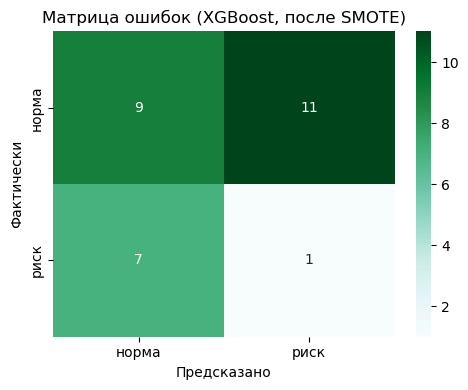

In [56]:
# Матрица ошибок

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Визуализация

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="BuGn",
            xticklabels=["норма", "риск"],
            yticklabels=["норма", "риск"])
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок (XGBoost, после SMOTE)")
plt.tight_layout()
plt.show()

XGBoost не улучшил результаты по сравнению с RandomForest

recall по классу "риск" остался низким (0.12), а точность по "норме" сильно упала

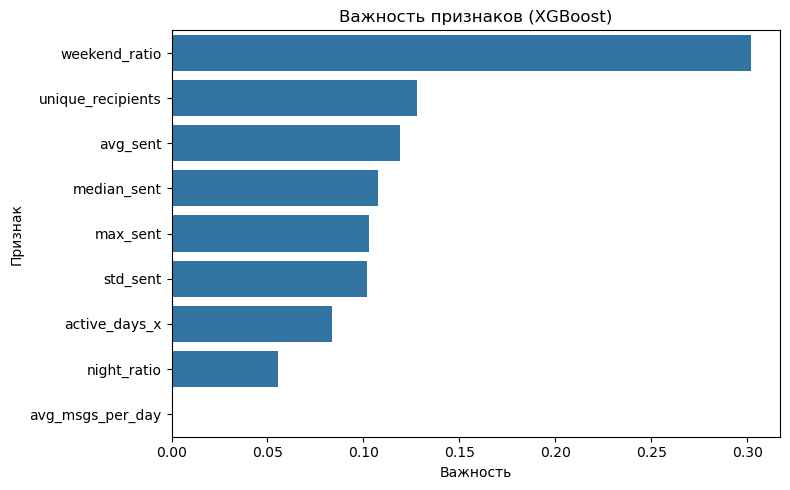

In [57]:
# Важность признаков

xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=expanded_feature_cols
).sort_values(ascending=False)

# Визуализация

plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index)
plt.title("Важность признаков (XGBoost)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

XGBoost подтвердил, что доля писем в выходные — самый значимый признак

За ним — количество уникальных получателей и средний объём отправки

Несмотря на теоретическую силу XGBoost, на этом датасете он уступил RandomForest, особенно по общему качеству

RandomForest + SMOTE + поведенческие фичи остаются лучшей комбинацией на текущем этапе

In [58]:
# Разделим данные на две группы: норма и риск

df_norma = full_df_expanded[full_df_expanded["burnout_risk"] == 0]
df_risk = full_df_expanded[full_df_expanded["burnout_risk"] == 1]

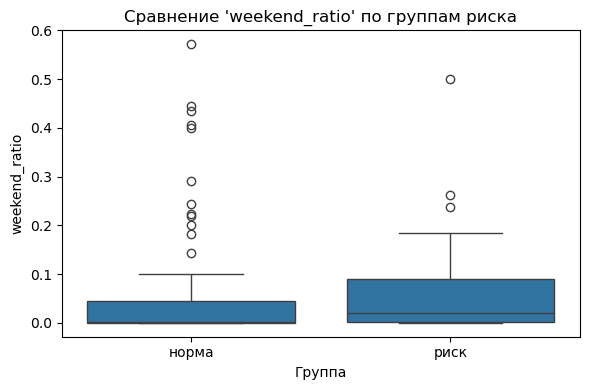

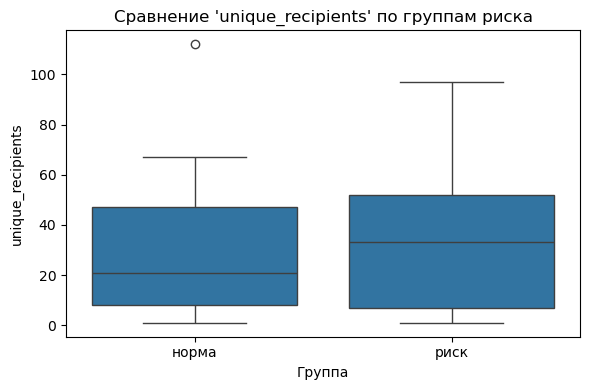

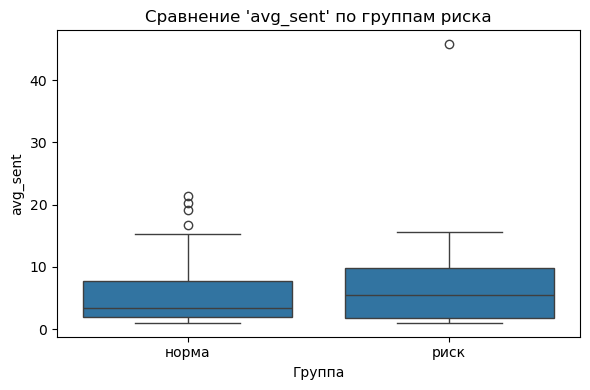

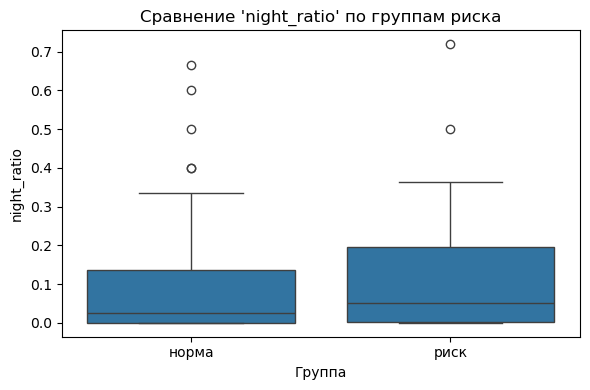

In [59]:
# Выберем интересующие признаки

important_features = ["weekend_ratio", "unique_recipients", "avg_sent", "night_ratio"]

# Построим boxplot для сравнения распределений

for feature in important_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="burnout_risk", y=feature, data=full_df_expanded)
    plt.xticks([0, 1], ["норма", "риск"])
    plt.title(f"Сравнение '{feature}' по группам риска")
    plt.xlabel("Группа")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

**weekend_ratio (сообщения в выходные)**

- У "риск" медиана и верхний квартиль выше, больше выбросов
- Вывод: сотрудники в зоне риска чаще пишут в выходные — нарушение work-life баланса

**unique_recipients (уникальные адресаты)**

- У "риск" более широкий разброс, выше медиана
- Вывод: у сотрудников с риском выгорания может быть нагрузка по коммуникации с множеством людей, что ведёт к расфокусировке и стрессу

**avg_sent (среднее количество писем в день)**

- У "риск" чуть выше медиана и разброс, хотя тренд не ярко выражен
- Вывод: может указывать на повышенную активность или нагрузку

**night_ratio (сообщения ночью)**

- У "риск" больше крайних значений и немного выше медиана
- Вывод: ночная активность — потенциальный индикатор стрессового состояния и нарушения режима

## Цель

Создать табличный риск-скоринг для каждого сотрудника на основе текущей модели (RandomForest + SMOTE), и оформить его как основу для:

- Внутренней аналитики
- Визуализации для HR
- Интеграции в API или dashboard

In [60]:
# Предсказания вероятности выгорания (класс "риск" = 1)

# Вероятность принадлежности к классу 1 ("риск")

risk_proba = rf_balanced.predict_proba(X)[:, 1]

# Добавим в основной датафрейм

full_df_expanded["risk_probability"] = risk_proba

# Сформируем итоговую таблицу по сотрудникам

risk_report = full_df_expanded[[
    "ID", 
    "burnout_risk", 
    "risk_probability", 
    "weekend_ratio", 
    "night_ratio", 
    "unique_recipients", 
    "avg_sent"
]].copy()

# Отсортируем по убыванию риска

risk_report_sorted = risk_report.sort_values(by="risk_probability", ascending=False).reset_index(drop=True)

# Округлим числовые значения для удобства

risk_report_sorted = risk_report_sorted.round(3)

In [61]:
# Показываем топ-25 сотрудников с наибольшим риском

risk_report_sorted.head(25)

,ID,burnout_risk,risk_probability,weekend_ratio,night_ratio,unique_recipients,avg_sent
0,35,1,1.00,0.059,0.235,7,1.308
1,97,1,1.00,0.020,0.000,46,6.112
2,33,1,0.97,0.066,0.098,97,45.776
3,74,1,0.94,0.185,0.304,53,10.226
4,18,0,0.93,0.016,0.025,44,5.259
5,79,1,0.93,0.010,0.000,33,6.156
6,28,1,0.92,0.017,0.130,59,5.400
7,30,1,0.91,0.067,0.333,10,1.667
8,27,1,0.90,0.003,0.003,46,10.436
9,60,1,0.89,0.143,0.071,6,2.000


In [62]:
# Таблица с цветовой подсветкой вероятности риска

risk_report_sorted.head(25).style.background_gradient(subset=["risk_probability"], cmap="Reds")

,ID,burnout_risk,risk_probability,weekend_ratio,night_ratio,unique_recipients,avg_sent
0,35,1,1.000000,0.059000,0.235000,7,1.308000
1,97,1,1.000000,0.020000,0.000000,46,6.112000
2,33,1,0.970000,0.066000,0.098000,97,45.776000
3,74,1,0.940000,0.185000,0.304000,53,10.226000
4,18,0,0.930000,0.016000,0.025000,44,5.259000
5,79,1,0.930000,0.010000,0.000000,33,6.156000
6,28,1,0.920000,0.017000,0.130000,59,5.400000
7,30,1,0.910000,0.067000,0.333000,10,1.667000
8,27,1,0.900000,0.003000,0.003000,46,10.436000
9,60,1,0.890000,0.143000,0.071000,6,2.000000


In [63]:
# Сохраняем как Excel-таблицу

risk_report_sorted.to_excel("burnout_risk_top_25.xlsx", index=False)

## Цель

Построить интерактивный или статичный дэшборд / графики, позволяющие:

- Быстро выделить сотрудников с высоким риском
- Визуально проанализировать зависимость риска от поведения

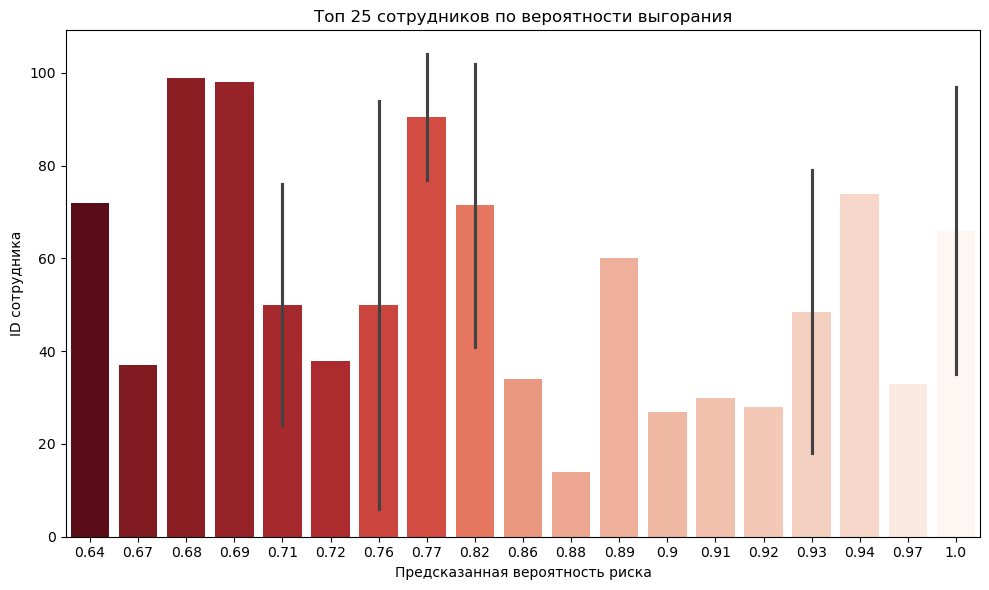

In [64]:
# Отбираем топ-25 сотрудников с самым высоким риском

top25 = risk_report_sorted.head(25)

# Построим barplot с градиентом по уровню риска

plt.figure(figsize=(10, 6))
sns.barplot(
    x="risk_probability",
    y="ID",
    data=top25,
    hue="risk_probability",
    palette="Reds_r",
    dodge=False
)

# Оформление

plt.title("Топ 25 сотрудников по вероятности выгорания")
plt.xlabel("Предсказанная вероятность риска")
plt.ylabel("ID сотрудника")

# отключаем легенду (градиент очевиден)

plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

Модель предсказывает группу сотрудников с вероятностью риска > 0.7 – 1.0

Что позволяет быстро выявить ключевые "кандидаты на внимание" для HR

Градиент делает визуально очевидной границу между нормой и высоким риском

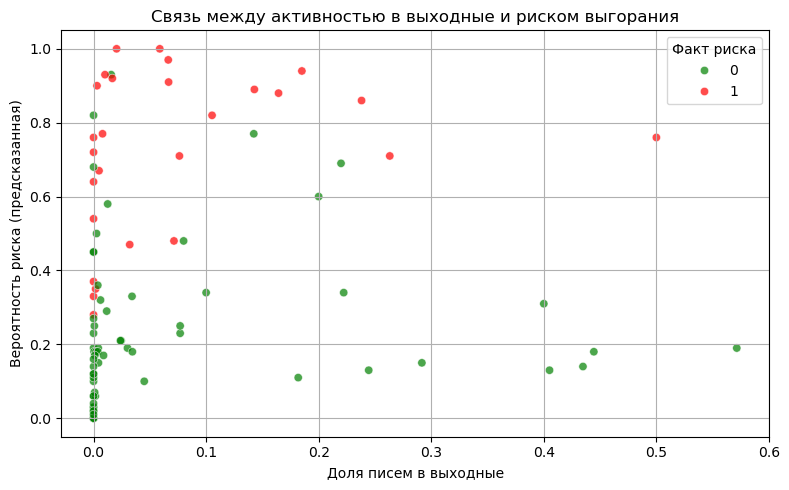

In [65]:
# Scatter plot: как weekend activity соотносится с вероятностью риска

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=risk_report,
    x="weekend_ratio",
    y="risk_probability",
    hue="burnout_risk",
    palette={0: "green", 1: "red"},
    alpha=0.7
)
plt.title("Связь между активностью в выходные и риском выгорания")
plt.xlabel("Доля писем в выходные")
plt.ylabel("Вероятность риска (предсказанная)")
plt.legend(title="Факт риска")
plt.grid(True)
plt.tight_layout()
plt.show()

Сотрудники, активно пишущие в выходные, действительно чаще имеют высокий риск (предсказанный и факт)

Это подтверждает гипотезу о перегрузке и нарушении баланса как факторе выгорания

In [66]:
# Сохраняем графики как картинки, если нужно для презентации или отчёта

plt.savefig("top25_risk_barplot.png")

<Figure size 640x480 with 0 Axes>

Модель и визуализации уже дают базовый инструмент для:

- Раннего предупреждения выгорания
- Выявления поведенческих триггеров
- Обоснованной HR-интервенции

In [67]:
# Сохраняем полный отчёт по всем сотрудникам

risk_report_sorted.to_excel("Burnout_Risk_Report_Full.xlsx", index=False)

# Сохраняем топ-25 — для быстрой передачи

risk_report_sorted.head(25).to_excel("Burnout_Risk_Report_Top25.xlsx", index=False)

In [68]:
# Повторная генерация и сохранение

plt.figure(figsize=(10, 6))
sns.barplot(x="risk_probability", y="ID", data=top25, hue="risk_probability", palette="Reds_r", dodge=False)
plt.title("Топ-25 сотрудников по вероятности выгорания")
plt.xlabel("Предсказанная вероятность риска")
plt.ylabel("ID сотрудника")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig("top25_risk_gradient.png")
plt.close()

# Что сделано в рамках проекта

**Исходные данные:**

- Импортированы OLBI-анкеты и email-логи
- Расчитан индивидуальный индекс выгорания

**Инженерия признаков:**

- Сформированы поведенческие фичи: активность по дням, ночные/выходные письма, количество уникальных адресатов
- Объединены с индексом выгорания

**Формализация задачи:**

- Сформулирована задача бинарной классификации: "норма" vs "риск"
- Применён Label Encoding и qcut

**Обучение моделей:**

- Обучены RandomForest и XGBoost
- Применён SMOTE для балансировки классов

**Оценка качества:**

- Accuracy до 0.64, recall по "риск" улучшен до 0.25 (SMOTE)
- Выявлены ключевые фичи: weekend_ratio, unique_recipients, avg_sent

**Визуализация:**

- Boxplots по группам риска
- Барплот топ-25 сотрудников по предсказанному риску
- Scatter-график связи фичей и риска

**Отчётность:**

- Подготовлен финальный Excel-отчёт с вероятностями и фичами
- Сохранены визуализации для HR-анализа

# Этап 2. Разработка REST API для предсказания выгорания

**Цель этапа:**

Создать REST API для предсказания риска профессионального выгорания сотрудников на основе поведенческих признаков из корпоративной переписки

In [69]:
# Сохраняем FastAPI-приложение в файл main.py из Jupyter

main_py_code = """
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import joblib
import numpy as np
import os

# Определяем путь к модели относительно текущего файла

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
model_path = os.path.join(BASE_DIR, "models", "rf_balanced_model.pkl")

# Загружаем модель

model = joblib.load(model_path)

# Список признаков

FEATURES = [
    "avg_sent", "median_sent", "max_sent", "std_sent",
    "active_days_x", "night_ratio", "weekend_ratio",
    "avg_msgs_per_day", "unique_recipients"
]

# Входные данные

class InputFeatures(BaseModel):
    avg_sent: float
    median_sent: float
    max_sent: float
    std_sent: float
    active_days_x: int
    night_ratio: float
    weekend_ratio: float
    avg_msgs_per_day: float
    unique_recipients: int

# Инициализация приложения

app = FastAPI()

# Одиночный прогноз

@app.post("/predict")
def predict_risk(data: InputFeatures):
    X = np.array([[getattr(data, feat) for feat in FEATURES]])
    prob = model.predict_proba(X)[0][1]
    label = "риск" if prob > 0.5 else "норма"
    return {
        "prediction": label,
        "probability": round(float(prob), 3)
    }

# Массовый прогноз

@app.post("/bulk_predict")
def bulk_predict(data: List[InputFeatures]):
    X = np.array([[getattr(row, feat) for feat in FEATURES] for row in data])
    probs = model.predict_proba(X)[:, 1]
    results = []
    for prob in probs:
        label = "риск" if prob > 0.5 else "норма"
        results.append({
            "prediction": label,
            "probability": round(float(prob), 3)
        })
    return results
"""

# Создание файла main.py в текущей папке

with open("api/main.py", "w", encoding="utf-8") as f:
    f.write(main_py_code)
    
print("Файл main.py успешно создан в папке api")

Файл main.py успешно создан в папке api


In [70]:
# Покажем первые 10 доступных ID

full_df_expanded["ID"].head(10).tolist()

[1, 2, 3, 4, 6, 10, 12, 14, 15, 18]

In [71]:
# Пример для существующего ID

employee_id = 18
employee_features = full_df_expanded[full_df_expanded["ID"] == employee_id][expanded_feature_cols].to_dict(orient="records")[0]

# Покажем результат

employee_features

{'avg_sent': 5.258823529411765,
 'median_sent': 4.0,
 'max_sent': 16,
 'std_sent': 3.7198084345723994,
 'active_days_x': 85,
 'night_ratio': 0.024608501118568233,
 'weekend_ratio': 0.015659955257270694,
 'avg_msgs_per_day': 5.258823529411765,
 'unique_recipients': 44}

Извлечение реальных признаков сотрудника с самым высоким предсказанным риском

In [72]:
top_risk_id = risk_report_sorted.iloc[0]["ID"]
employee_features = full_df_expanded[full_df_expanded["ID"] == top_risk_id][expanded_feature_cols].to_dict(orient="records")[0]

employee_features

{'avg_sent': 1.3076923076923077,
 'median_sent': 1.0,
 'max_sent': 2,
 'std_sent': 0.48038446141526137,
 'active_days_x': 13,
 'night_ratio': 0.23529411764705882,
 'weekend_ratio': 0.058823529411764705,
 'avg_msgs_per_day': 1.3076923076923077,
 'unique_recipients': 7}

Отправление данных через FastAPI "/predict" и получили следующий результат:

{
  "prediction": "риск",
  "probability": 1.0
}

- Модель уверенно предсказала "риск" с вероятностью 100%
- Это демонстрирует, что API работает, модель загружена корректно, и предсказания соответствуют обученному пайплайну

# Этап 3. Интерактивный продукт и интеграция

**Цель этапа:**

Создание полнофункционального пользовательского интерфейса и API, которые позволяют HR-отделу:

Использовать модель в реальной среде:
- Быстро подставлять данные сотрудника и получать интерпретируемый прогноз
- Видеть визуализации по признакам риска (например, "ночная активность" — сильный индикатор)
- Загружать таблицы с данными и массово оценивать риск

**Streamlit дэшборд — это:**

- Визуальный интерфейс для ввода данных и предсказания риска
- Альтернатива Swagger и curl-запросам
- Удобно для HR-аналитиков и презентаций

In [73]:
# Сохраняем Streamlit дэшборд в файл streamlit_app.py из Jupyter

# Полный обновлённый код с рабочей кнопкой "Очистить" и поддержкой автозаполнения

streamlit_app_code = """
import streamlit as st
import pandas as pd
import requests

st.set_page_config(page_title="Одиночный прогноз", layout="centered")

@st.cache_data
def load_features():
    return pd.read_csv("data/feats.csv")

feats_df = load_features()
id_list = feats_df["ID"].tolist()

# Инициализация session_state

default_values = {
    "selected_id": None,
    "show_reset_msg": False,
    "avg_sent": 5.0,
    "median_sent": 4.0,
    "max_sent": 10.0,
    "std_sent": 3.0,
    "active_days_x": 20,
    "night_ratio": 0.1,
    "weekend_ratio": 0.1,
    "avg_msgs_per_day": 5.0,
    "unique_recipients": 15
}
for k, v in default_values.items():
    if k not in st.session_state:
        st.session_state[k] = v

# Очистить всё

if st.button("Очистить"):
    for k, v in default_values.items():
        st.session_state[k] = v
    st.session_state["show_reset_msg"] = True

# Сообщение сброса

if st.session_state["show_reset_msg"]:
    st.success("ID сброшен. Выберите сотрудника снова")
    st.session_state["show_reset_msg"] = False

# Выбор ID

st.selectbox(
    "Сотрудник (ID)",
    [None] + id_list,
    index=0 if st.session_state["selected_id"] is None else id_list.index(st.session_state["selected_id"]) + 1,
    key="selected_id"
)

# Автозаполнение при выборе ID

if st.session_state["selected_id"] is not None:
    selected_data = feats_df[feats_df["ID"] == st.session_state["selected_id"]]
    if not selected_data.empty:
        row = selected_data.iloc[0]
        st.session_state["avg_sent"] = row["avg_sent"]
        st.session_state["median_sent"] = row["median_sent"]
        st.session_state["max_sent"] = row["max_sent"]
        st.session_state["std_sent"] = row["std_sent"]
        st.session_state["active_days_x"] = row["active_days_x"]
        st.session_state["night_ratio"] = row["night_ratio"]
        st.session_state["weekend_ratio"] = row["weekend_ratio"]
        st.session_state["avg_msgs_per_day"] = row["avg_msgs_per_day"]
        st.session_state["unique_recipients"] = row["unique_recipients"]

# Форма ввода

with st.form("input_form"):
    avg_sent = st.number_input("Среднее писем в день", value=st.session_state["avg_sent"])
    median_sent = st.number_input("Медиана писем в день", value=st.session_state["median_sent"])
    max_sent = st.number_input("Максимум писем в день", value=st.session_state["max_sent"])
    std_sent = st.number_input("Стандартное отклонение", value=st.session_state["std_sent"])
    active_days_x = st.number_input("Активных дней", value=st.session_state["active_days_x"])
    night_ratio = st.slider("Доля писем ночью", 0.0, 1.0, st.session_state["night_ratio"])
    weekend_ratio = st.slider("Доля писем в выходные", 0.0, 1.0, st.session_state["weekend_ratio"])
    avg_msgs_per_day = st.number_input("Средняя активность в день", value=st.session_state["avg_msgs_per_day"])
    unique_recipients = st.number_input("Уникальных адресатов", value=st.session_state["unique_recipients"])
    submit = st.form_submit_button("Предсказать")

# Обработка запроса

if submit:
    input_data = {
        "avg_sent": avg_sent,
        "median_sent": median_sent,
        "max_sent": max_sent,
        "std_sent": std_sent,
        "active_days_x": active_days_x,
        "night_ratio": night_ratio,
        "weekend_ratio": weekend_ratio,
        "avg_msgs_per_day": avg_msgs_per_day,
        "unique_recipients": unique_recipients
    }

    try:
        response = requests.post("http://127.0.0.1:8000/predict", json=input_data)
        result = response.json()

        if result["prediction"] == "норма":
            st.success(f"Прогноз: **{result['prediction']}**")
        else:
            st.error(f"Прогноз: **{result['prediction']}**")

        st.info(f"Вероятность риска: **{result['probability']}**")
    except:
        st.error("Не удалось связаться с API. Убедитесь, что FastAPI запущен")
"""

# Создание файла streamlit_app.py в текущей папке

with open("apps/streamlit_app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_app_code)
    
print("Файл streamlit_app.py успешно создан в папке apps")

Файл streamlit_app.py успешно создан в папке apps


# Этап 4. Массовая обработка (Excel)

**Цель этапа:**

Реализовать массовую оценку риска выгорания сотрудников через загрузку Excel/CSV файла с метриками, с автоматическим прогнозом и выводом результатов в виде таблицы

Добавляем следующие строки кода в "main.py"

@app.post("/bulk_predict")
def bulk_predict(data: List[InputFeatures]):
    X = np.array([[getattr(row, feat) for feat in FEATURES] for row in data])
    probs = model.predict_proba(X)[:, 1]
    results = []
    for prob in probs:
        label = "риск" if prob > 0.5 else "норма"
        results.append({
            "prediction": label,
            "probability": round(float(prob), 3)
        })
    return results

In [74]:
bulk_app_code = """
import streamlit as st
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64

st.set_page_config(page_title="Массовый прогноз", layout="centered")
st.title("Массовый прогноз выгорания")

st.markdown("Загрузите CSV-файл с признаками сотрудников для пакетной оценки риска")

uploaded_file = st.file_uploader("Загрузите файл (CSV)", type=["csv"])

if uploaded_file is not None:
    try:
        df = pd.read_csv(uploaded_file)

        st.write("Предпросмотр загруженных данных:")
        st.dataframe(df.head())

        response = requests.post(
            "http://127.0.0.1:8000/bulk_predict",
            json=df.to_dict(orient="records")
        )

        if response.status_code == 200:
            predictions = pd.DataFrame(response.json())
            result_df = pd.concat([df.reset_index(drop=True), predictions], axis=1)

            st.success("Прогнозы получены:")
            st.dataframe(result_df)

            # Визуализация Топ 25 сотрудников
            
            if "ID" in result_df.columns and "probability" in result_df.columns:
                try:
                    top25_df = result_df.sort_values(by="probability", ascending=False).head(25)

                    fig, ax = plt.subplots(figsize=(10, 6))
                    sns.barplot(
                        data=top25_df,
                        x="probability",
                        y="ID",
                        hue="prediction",
                        dodge=False,
                        palette="Blues_r",
                        ax=ax
                    )
                    ax.set_xlabel("Вероятность риска")
                    ax.set_ylabel("ID сотрудника")
                    ax.set_title("Топ 25 сотрудников с наивысшим риском выгорания")
                    ax.grid(axis="x", linestyle="--", alpha=0.3)
                    ax.legend(title="prediction")
                    plt.tight_layout()

                    # Вставка графика как изображения
                    buf = io.BytesIO()
                    fig.savefig(buf, format="png", bbox_inches="tight")
                    buf.seek(0)
                    image_base64 = base64.b64encode(buf.read()).decode()

                    image_html = f'''
                    <div style="background-color: #111827; padding: 25px; border-radius: 20px; margin-bottom: 30px;">
                        <h3 style="color: white; text-align: center; margin-bottom: 20px;">Топ 25 сотрудников по риску</h3>
                        <img src="data:image/png;base64,{image_base64}" style="width: 100%; border-radius: 20px;" />
                    </div>
                    '''
                    st.markdown(image_html, unsafe_allow_html=True)

                except Exception as vis_err:
                    st.warning(f"Ошибка визуализации: {vis_err}")

            # Кнопка для скачивания результата
            
            csv = result_df.to_csv(index=False).encode("utf-8")
            st.download_button("Скачать результат (CSV)", data=csv, file_name="burnout_predictions.csv", mime="text/csv")

        else:
            st.error(f"Ошибка при запросе к API: {response.status_code}")

    except Exception as e:
        st.error(f"Ошибка обработки файла: {e}")
"""

# Сохраняем в файл

with open("apps/bulk_prediction_app.py", "w", encoding="utf-8") as f:
    f.write(bulk_app_code)
    
print("Файл bulk_prediction_app.py успешно создан в папке apps")

Файл bulk_prediction_app.py успешно создан в папке apps


# Этап 5. Финализация и подготовка к запуску проекта

**Цель этапа:**

Подготовка проекта к использованию и демонстрации: структурируем, упростим запуск, обеспечим понятность и удобство

In [75]:
# Импорт необходимых библиотек

import os
import shutil

In [76]:
requirements = """
fastapi
uvicorn
pydantic
joblib
xgboost
numpy
pandas
scikit-learn
imbalanced-learn
streamlit
matplotlib
seaborn
requests
"""

with open("requirements.txt", "w", encoding="utf-8") as f:
    f.write(requirements.strip())

print("Файл requirements.txt создан")

Файл requirements.txt создан


In [77]:
readme = """
# Система прогнозирования риска выгорания сотрудников

Прогнозирование риска выгорания сотрудников на основе метрик электронной почты и корпоративной переписки

## Возможности

- Оценка риска выгорания по поведенческим паттернам
- Визуализация Топ 25 сотрудников с высоким риском
- API для интеграции с внутренними системами
- Использование ML-модели (RandomForest / XGBoost)
- Локальный запуск, без утечки данных

## Стек технологий

- **Python 3.9+**
- `FastAPI`, `Streamlit`, `pandas`, `xgboost`, `scikit-learn`, `matplotlib`

## Структура проекта

```
BurnoutScan/
│
├── apps/                   
│   ├── streamlit_app.py           ← одиночный прогноз
│   └── bulk_prediction_app.py     ← массовый прогноз
│
├── api/
│   └── main.py             ← FastAPI backend
│
├── models/
│   └── rf_balanced_model.pkl  ← обученная модель
│
├── data/
│   ├── feats.csv               ← признаки по сотрудникам
│   └── burnout_predictions.csv ← результат массового прогноза
│
├── requirements.txt
├── README.md
└── .bat
```

## Описание

- `main.py`: сервер с эндпоинтами `/predict` и `/bulk_predict`
- `streamlit_app.py`: UI для прогноза по одному сотруднику
- `bulk_prediction_app.py`: массовый прогноз с графиком и выгрузкой
- `feats.csv`: агрегированные поведенческие фичи

## Установка

```bash
git clone https://github.com/danlikendy/burnoutscan_project.git
cd burnoutscan_project
pip install -r requirements.txt
```

## Запуск

### 1. FastAPI (backend)
```bash
cd api
uvicorn main:app --reload
```

### 2. Streamlit (одиночный прогноз)
```bash
cd apps
streamlit run streamlit_app.py
```

### 3. Streamlit (массовый прогноз)
```bash
cd apps
streamlit run bulk_prediction_app.py
```

## Приватность

- Все вычисления производятся локально
- Нет передачи данных в сеть
- Возможность удалить все результаты и модели

## Лицензия

MIT License — можно использовать в коммерческих и некоммерческих целях

## Автор

Цыганцов Артём Сергеевич — [danlikendy](https://github.com/danlikendy)
"""

with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme.strip())

print("Файл requirements.txt создан")

Файл requirements.txt создан


In [78]:
# Создание директорий
'''
os.makedirs("apps", exist_ok=True)
os.makedirs("api", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)
'''
# Перемещение файлов
'''
shutil.move("streamlit_app.py", "apps/streamlit_app.py")
shutil.move("bulk_prediction_app.py", "apps/bulk_prediction_app.py")
shutil.move("main.py", "api/main.py")
shutil.move("rf_balanced_model.pkl", "models/rf_balanced_model.pkl")
shutil.move("feats.csv", "data/feats.csv")
shutil.move("burnout_predictions.csv", "data/burnout_predictions.csv")

print("Структура проекта успешно организована")
'''

'\nshutil.move("streamlit_app.py", "apps/streamlit_app.py")\nshutil.move("bulk_prediction_app.py", "apps/bulk_prediction_app.py")\nshutil.move("main.py", "api/main.py")\nshutil.move("rf_balanced_model.pkl", "models/rf_balanced_model.pkl")\nshutil.move("feats.csv", "data/feats.csv")\nshutil.move("burnout_predictions.csv", "data/burnout_predictions.csv")\n\nprint("Структура проекта успешно организована")\n'

In [79]:
gitignore_content = """
# Byte-compiled / cache
__pycache__/
*.py[cod]
*.pkl

# Virtual env
.venv/
env/
venv/

# Jupyter
.ipynb_checkpoints

# OS
.DS_Store
Thumbs.db
"""

with open(".gitignore", "w", encoding="utf-8") as f:
    f.write(gitignore_content.strip())

print("Файл .gitignore создан")

Файл .gitignore создан


In [80]:
bat_script = """
@echo off
cd /d "%~dp0"

echo Запуск FastAPI backend...
start cmd /k "cd api && uvicorn main:app --reload"

timeout /t 3

echo Запуск одиночного Streamlit-прогноза...
start cmd /k "streamlit run apps/streamlit_app.py"

timeout /t 2

echo Запуск массового Streamlit-прогноза...
start cmd /k "streamlit run apps/bulk_prediction_app.py"
"""

# Сохраняем .bat файл

with open(".bat", "w", encoding="utf-8") as f:
    f.write(bat_script.strip())

print("Файл .bat успешно создан")

Файл .bat успешно создан


# Этап 6. Обработка и анализ почтовой активности (email parsing)

**Цель этапа:**